In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy
import csv

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'car', 'bird', 'cat'}
fg_used = '123'
fg1, fg2, fg3 = 1,2,3


all_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}
background_classes = all_classes - foreground_classes
background_classes

# print(type(foreground_classes))

{'deer', 'dog', 'frog', 'horse', 'plane', 'ship', 'truck'}

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

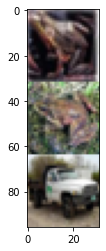

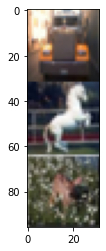

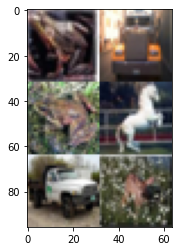

torch.Size([3, 96, 32])


In [0]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in range(desired_num):
  set_idx = set()
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)
  list_set_labels.append(set_idx)


3


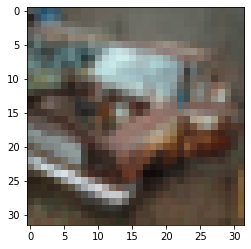

plane


In [0]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]]) 

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [0]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.module1 = Module1().double()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,z):  #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    x = x.to("cuda")
    y = y.to("cuda")
    for i in range(9):
        x[:,i] = self.module1.forward(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
      y = y.contiguous()


    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.contiguous()
    y1 = y1.reshape(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 , x, y

In [0]:
fore_net = Module2().double()
fore_net = fore_net.to("cuda")

In [0]:
fore_net.load_state_dict(torch.load("/content/drive/My Drive/Research/drill_deep_cifar/weights/fore_net_epoch163_fg_used123.pt"))

<All keys matched successfully>

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(fore_net.parameters(), lr=0.01, momentum=0.9)
nos_epochs = 600

for epoch in range(nos_epochs):  # loop over the dataset multiple times

  running_loss = 0.0
  cnt=0
  mini_loss = []

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels, fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    # zero the parameter gradients
    
    # optimizer_what.zero_grad()
    # optimizer_where.zero_grad()
    optimizer.zero_grad()
    
    # avg_images , alphas = where_net(inputs)
    # avg_images = avg_images.contiguous()
    # outputs = what_net(avg_images)

    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels) 
    loss.backward()
    # optimizer_what.step()
    # optimizer_where.step()
    optimizer.step()
    running_loss += loss.item()
    mini = 40
  
    if cnt % mini == mini - 1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      mini_loss.append(running_loss / mini)
      running_loss = 0.0
      
    cnt=cnt+1
  if(np.average(mini_loss) <= 0.05):
    break
print('Finished Training')
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")

[1,    40] loss: 0.788
[1,    80] loss: 0.551
[1,   120] loss: 0.522
[2,    40] loss: 0.465
[2,    80] loss: 0.467
[2,   120] loss: 0.459
[3,    40] loss: 0.422
[3,    80] loss: 0.424
[3,   120] loss: 0.435
[4,    40] loss: 0.387
[4,    80] loss: 0.405
[4,   120] loss: 0.408
[5,    40] loss: 0.364
[5,    80] loss: 0.376
[5,   120] loss: 0.369
[6,    40] loss: 0.354
[6,    80] loss: 0.355
[6,   120] loss: 0.363
[7,    40] loss: 0.336
[7,    80] loss: 0.336
[7,   120] loss: 0.336
[8,    40] loss: 0.314
[8,    80] loss: 0.328
[8,   120] loss: 0.330
[9,    40] loss: 0.307
[9,    80] loss: 0.313
[9,   120] loss: 0.319
[10,    40] loss: 0.291
[10,    80] loss: 0.313
[10,   120] loss: 0.307
[11,    40] loss: 0.290
[11,    80] loss: 0.298
[11,   120] loss: 0.308
[12,    40] loss: 0.277
[12,    80] loss: 0.301
[12,   120] loss: 0.281
[13,    40] loss: 0.260
[13,    80] loss: 0.259
[13,   120] loss: 0.275
[14,    40] loss: 0.249
[14,    80] loss: 0.272
[14,   120] loss: 0.258
[15,    40] loss: 0

In [0]:
# torch.save(fore_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/fore_net_epoch"+str(epoch)+"_fg_used"+str(fg_used)+".pt")

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
test_set_labels = []
for i in range(10000):
  set_idx = set()
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)
  test_set_labels.append(set_idx)


In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [23]:
torch.argmax(alphas[5]), alphas[5]

(tensor(2, device='cuda:0', grad_fn=<NotImplemented>),
 tensor([8.7618e-03, 5.6977e-04, 9.5186e-01, 6.1583e-03, 8.7617e-03, 2.3425e-03,
         3.5168e-04, 1.9761e-02, 1.4362e-03], device='cuda:0',
        dtype=torch.float64, grad_fn=<SelectBackward>))

In [24]:
fg = [fg1, fg2, fg3]
all_list = [0,1,2,3,4,5,6,7,8,9]
bg = list(set(all_list)-set(fg))
fg, bg

([1, 2, 3], [0, 4, 5, 6, 7, 8, 9])

In [0]:
test_set = DataLoader( test_data,batch_size= batch ,shuffle=False)
train_set = DataLoader( msd,batch_size= batch ,shuffle=False)

#TRAIN SUMMARY

In [26]:
from tabulate import tabulate
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_set:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)
print(count)

print("="*100)
table3 = []
entry = [1,'fg = '+ str(fg),'bg = '+str(bg),30000]
entry.append((100 * focus_true_pred_true / total))
entry.append( (100 * focus_false_pred_true / total))
entry.append( ( 100 * focus_true_pred_false / total))
entry.append( ( 100 * focus_false_pred_false / total))
entry.append( argmax_more_than_half)

train_entry = entry

table3.append(entry)

print(tabulate(table3, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )


Accuracy of the network on the 30000 train images: 98 %
total correct 29466
total train set images 30000
focus_true_pred_true 21971 =============> FTPT : 73 %
focus_false_pred_true 7495 =============> FFPT : 24 %
focus_true_pred_false 92 =============> FTPF : 0 %
focus_false_pred_false 442 =============> FFPF : 1 %
argmax_more_than_half 24397
argmax_less_than_half 5603
30000
  S.No.  fg_class        bg_class                      data_points     FTPT     FFPT      FTPF     FFPF    avg_img > 0.5
-------  --------------  --------------------------  -------------  -------  -------  --------  -------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          30000  73.2367  24.9833  0.306667  1.47333            24397


#TEST SUMMARY

In [27]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_set:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

print("="*100)
table4 = []
entry = [1,'fg = '+ str(fg),'bg = '+str(bg),10000]
entry.append((100 * focus_true_pred_true / total))
entry.append( (100 * focus_false_pred_true / total))
entry.append( ( 100 * focus_true_pred_false / total))
entry.append( ( 100 * focus_false_pred_false / total))
entry.append( argmax_more_than_half)

test_entry = entry 

table4.append(entry)

print(tabulate(table4, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )


Accuracy of the network on the 10000 test images: 80 %
total correct 8037
total train set images 10000
focus_true_pred_true 6496 =============> FTPT : 64 %
focus_false_pred_true 1541 =============> FFPT : 15 %
focus_true_pred_false 423 =============> FTPF : 4 %
focus_false_pred_false 1540 =============> FFPF : 15 %
argmax_more_than_half 7664
argmax_less_than_half 2336
  S.No.  fg_class        bg_class                      data_points    FTPT    FFPT    FTPF    FFPF    avg_img > 0.5
-------  --------------  --------------------------  -------------  ------  ------  ------  ------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          10000   64.96   15.41    4.23    15.4             7664


#Lets see the % of FTPT, FFPT, FTPF, FFPF for FG classes separetly

In [28]:
from tabulate import tabulate
table1 = []
table1.append(train_entry)
entry_no = 2


# cnt=0
for a in fg :
  count = 0
  correct = 0
  total = 0
  focus_true_pred_true = 0
  focus_false_pred_true = 0
  focus_true_pred_false = 0
  focus_false_pred_false = 0
  argmax_more_than_half = 0
  argmax_less_than_half = 0
  with torch.no_grad():
    for data in train_set:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)

      for m in range(labels.size(0)):
        # count
        if(count == 30000):
          break
        s = list_set_labels[count]
        # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
        if (a in s ):
          # print(str(a)+str(b1)+str(b2)+str(b3))
          total += 1
          focus = torch.argmax(alphas[m])
          if alphas[m][focus] >= 0.5 :
            argmax_more_than_half += 1
          else:
            argmax_less_than_half += 1

          if(focus == fore_idx[m] and predicted[m] == labels[m]):
              focus_true_pred_true += 1
          elif(focus != fore_idx[m] and predicted[m] == labels[m]):
            focus_false_pred_true += 1
          elif(focus == fore_idx[m] and predicted[m] != labels[m]):
            focus_true_pred_false += 1
          elif(focus != fore_idx[m] and predicted[m] != labels[m]):
            focus_false_pred_false += 1
        
        count += 1
      
    correct += (predicted == labels).sum().item()  
    entry = [entry_no,'fg = '+str(a) , 'bg = all_except_fg', total]
    if total == 0:
      entry.append(0)
      entry.append(0)
      entry.append(0)
      entry.append(0)
    else:
      entry.append((100 * focus_true_pred_true / total))
      entry.append( (100 * focus_false_pred_true / total))
      entry.append( ( 100 * focus_true_pred_false / total))
      entry.append( ( 100 * focus_false_pred_false / total))
    entry.append( argmax_more_than_half)
    table1.append(entry)
    entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(table1, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          30000    73.2367   24.9833    0.306667   1.47333             24397
      2  fg = 1          bg = all_except_fg                  10082    95.3283    3.97739   0.109105   0.585201             9919
      3  fg = 2          bg = all_except_fg                  10034    69.404    29.7987    0.17939    0.617899             7894
      4  fg = 3          bg = all_except_fg                   9884    54.5933   41.5217    0.637394   3.24767              6584


In [29]:
# for testing_set
table2 = []
table2.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  count = 0
  correct = 0
  total = 0
  focus_true_pred_true = 0
  focus_false_pred_true = 0
  focus_true_pred_false = 0
  focus_false_pred_false = 0
  argmax_more_than_half = 0
  argmax_less_than_half = 0
  with torch.no_grad():
    for data in test_set:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)

      for m in range(labels.size(0)):
        # count
        if(count == 10000):
          break
        s = list_set_labels[count]
        # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
        if (a in s ):
          # print(str(a)+str(b1)+str(b2)+str(b3))
          total += 1
          focus = torch.argmax(alphas[m])
          if alphas[m][focus] >= 0.5 :
            argmax_more_than_half += 1
          else:
            argmax_less_than_half += 1

          if(focus == fore_idx[m] and predicted[m] == labels[m]):
              focus_true_pred_true += 1
          elif(focus != fore_idx[m] and predicted[m] == labels[m]):
            focus_false_pred_true += 1
          elif(focus == fore_idx[m] and predicted[m] != labels[m]):
            focus_true_pred_false += 1
          elif(focus != fore_idx[m] and predicted[m] != labels[m]):
            focus_false_pred_false += 1
        
        count += 1
      
    correct += (predicted == labels).sum().item()  
    entry = [entry_no,'fg = '+str(a) , 'bg = all_except_fg', total]
    if total == 0:
      entry.append(0)
      entry.append(0)
      entry.append(0)
      entry.append(0)
    else:
      entry.append((100 * focus_true_pred_true / total))
      entry.append( (100 * focus_false_pred_true / total))
      entry.append( ( 100 * focus_true_pred_false / total))
      entry.append( ( 100 * focus_false_pred_false / total))
    entry.append( argmax_more_than_half)
    table2.append(entry)
    entry_no += 1

print("="*20+"Testing DATA"+"="*20)
print(tabulate(table2, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Testing DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          10000    64.96      15.41      4.23       15.4                7664
      2  fg = 1          bg = all_except_fg                   3336    64.1487    15.9472    3.98681    15.9173             2553
      3  fg = 2          bg = all_except_fg                   3368    64.3409    16.3302    4.0677     15.2613             2579
      4  fg = 3          bg = all_except_fg                   3296    66.4138    13.926     4.64199    15.0182             2532


#Set Size 1 
##3 not in BG, 4 not in BG, 5 not in BG and so on
## On Training DATA


In [30]:
size1_table=[]
size1_table.append(train_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    b1 = i
    count = 0
    correct = 0
    total = 0
    focus_true_pred_true = 0
    focus_false_pred_true = 0
    focus_true_pred_false = 0
    focus_false_pred_false = 0
    argmax_more_than_half = 0
    argmax_less_than_half = 0
    with torch.no_grad():
      for data in train_set:
        inputs, labels , fore_idx = data
        inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
        outputs, alphas, avg_images = fore_net(inputs)

        _, predicted = torch.max(outputs.data, 1)

        for m in range(labels.size(0)):
          # count
          if(count == 30000):
            break
          s = list_set_labels[count]
          # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
          if (a in s and b1 not in s ):
            # print(str(a)+str(b1)+str(b2)+str(b3))
            total += 1
            focus = torch.argmax(alphas[m])
            if alphas[m][focus] >= 0.5 :
              argmax_more_than_half += 1
            else:
              argmax_less_than_half += 1

            if(focus == fore_idx[m] and predicted[m] == labels[m]):
                focus_true_pred_true += 1
            elif(focus != fore_idx[m] and predicted[m] == labels[m]):
              focus_false_pred_true += 1
            elif(focus == fore_idx[m] and predicted[m] != labels[m]):
              focus_true_pred_false += 1
            elif(focus != fore_idx[m] and predicted[m] != labels[m]):
              focus_false_pred_false += 1
          
          count += 1
        
      correct += (predicted == labels).sum().item()  
      entry = [entry_no,'fg = '+str(a) , 'bg != '+ str(b1), total]
      if total == 0:
        entry.append(0)
        entry.append(0)
        entry.append(0)
        entry.append(0)
      else:
        entry.append((100 * focus_true_pred_true / total))
        entry.append( (100 * focus_false_pred_true / total))
        entry.append( ( 100 * focus_true_pred_false / total))
        entry.append( ( 100 * focus_false_pred_false / total))
      entry.append( argmax_more_than_half)
      size1_table.append(entry)
      entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(size1_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          30000    73.2367   24.9833   0.306667    1.47333             24397
      2  fg = 1          bg != 0                              2929    94.9129    4.26767  0.136565    0.682827             2873
      3  fg = 1          bg != 4                              2938    95.3029    4.01634  0.136147    0.544588             2896
      4  fg = 1          bg != 5                              2910    95.4296    3.88316  0.0343643   0.652921             2861
      5  fg = 1          bg != 6                              2953    95.022     4.16526  0.169319    0.643413             2901
      6  fg = 1          bg != 7                  

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_" + str(fg_used) + "/" + "size1_on_train.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size1_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size1_table[i])

In [32]:
train = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_"+str(fg_used) + "/" + "size1_on_train.csv")
train.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [1, 2, 3]  ...  1.473333          24397
1      2          fg = 1  ...  0.682827           2873
2      3          fg = 1  ...  0.544588           2896
3      4          fg = 1  ...  0.652921           2861
4      5          fg = 1  ...  0.643413           2901

[5 rows x 9 columns]

In [33]:
train = np.array(train)
ftpt_full = train[0][4]
ffpt_full = train[0, 5]
ftpf_full = train[0, 6]
ffpf_full = train[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,7  
id0 = train[l:u, 2]
ftpt0 = train[l:u, 4]
ffpt0 = train[l:u, 5]
ftpf0 = train[l:u, 6]
ffpf0 = train[l:u, 7]
print(ftpt0 , id0)

l,u = 8,14
id1 = train[l:u, 2]
ftpt1 = train[l:u, 4]
ffpt1 = train[l:u, 5]
ftpf1 = train[l:u, 6]
ffpf1 = train[l:u, 7]
print(ftpt1 , id1)

l,u = 15,21
id2 = train[l:u, 2]
ftpt2 = train[l:u, 4]
ffpt2 = train[l:u, 5]
ftpf2 = train[l:u, 6]
ffpf2 = train[l:u, 7]
print(ftpt2 , id2)

73.23666666666666 24.98333333333333 0.30666666666666664 1.4733333333333334
[94.91293956981905 95.30292716133422 95.42955326460479 95.02201151371487
 95.08582968697408 95.51878662530163] ['bg != 0' 'bg != 4' 'bg != 5' 'bg != 6' 'bg != 7' 'bg != 8']
[70.12320328542093 70.42974079126877 69.57417582417581 68.82051282051282
 68.92635925671026 68.06575725778244] ['bg != 0' 'bg != 4' 'bg != 5' 'bg != 6' 'bg != 7' 'bg != 8']
[53.84883315917799 55.92857142857143 56.17433414043583 55.68141592920354
 54.3403964456596 53.99239543726237] ['bg != 0' 'bg != 4' 'bg != 5' 'bg != 6' 'bg != 7' 'bg != 8']


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_' + str(fg_used) + "/size1/train/"

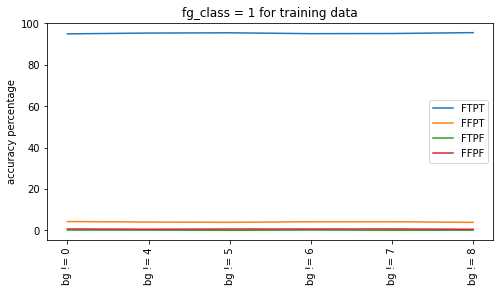

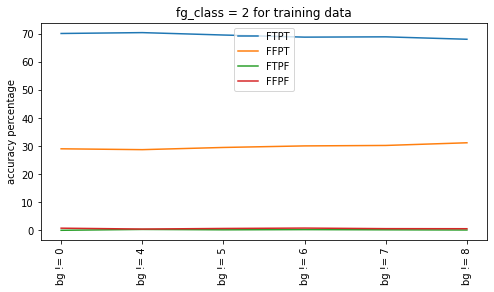

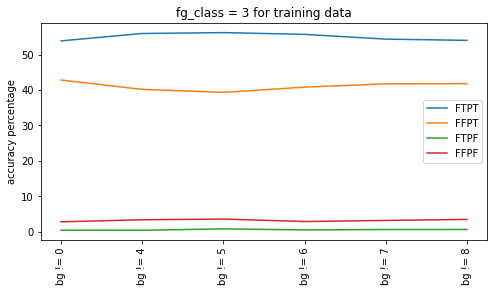

In [35]:
fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for training data'+".pdf", bbox_inches='tight')

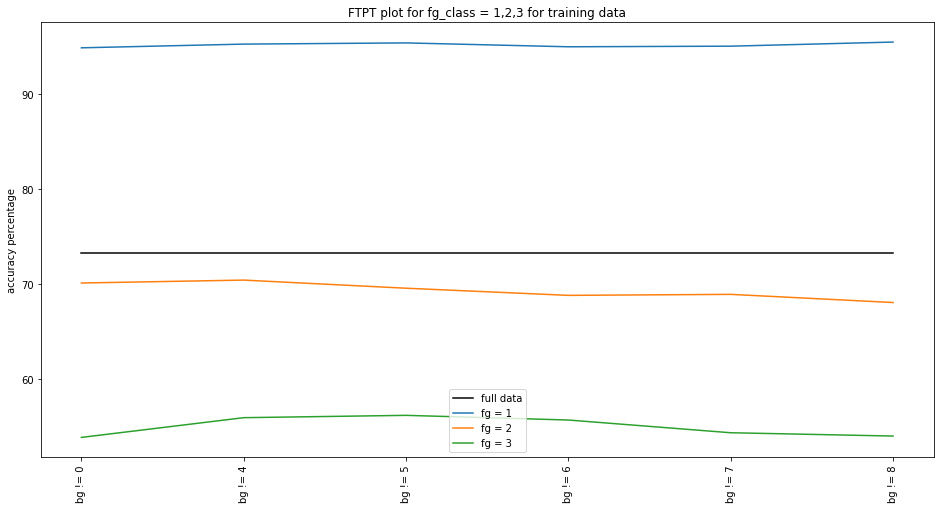

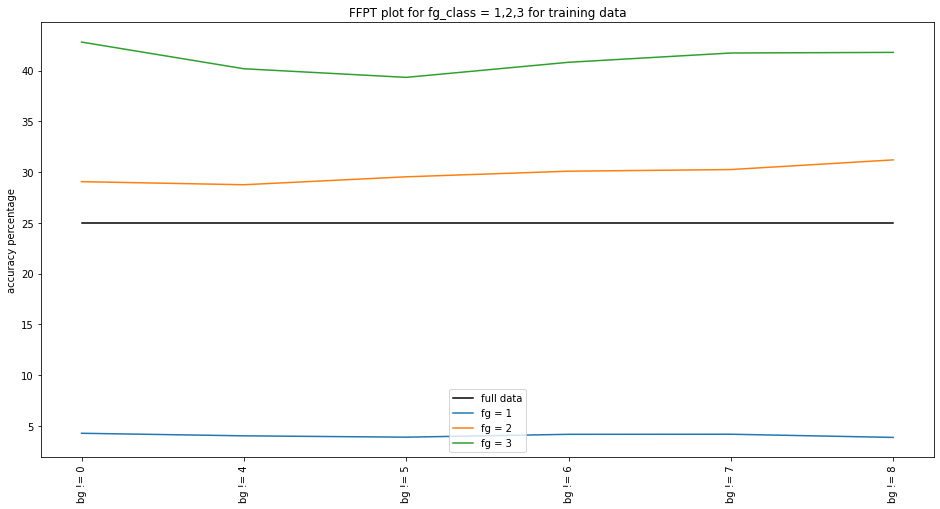

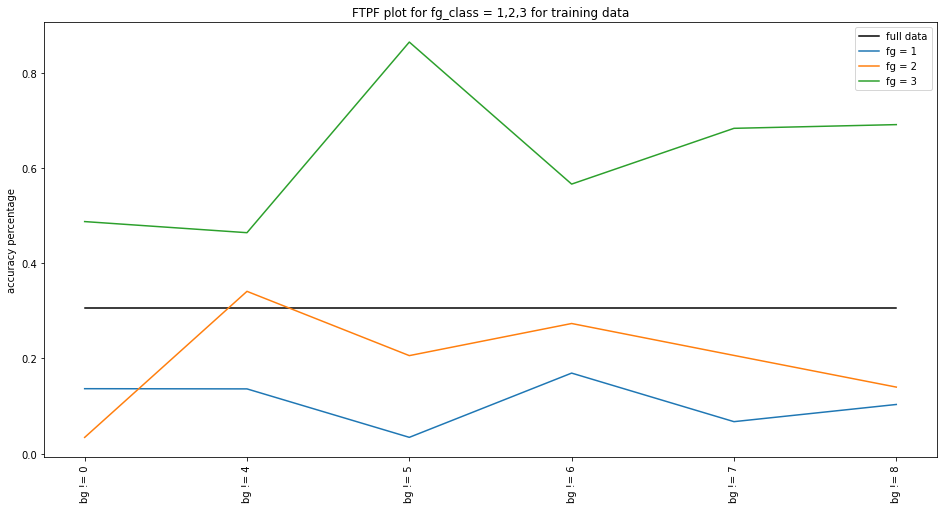

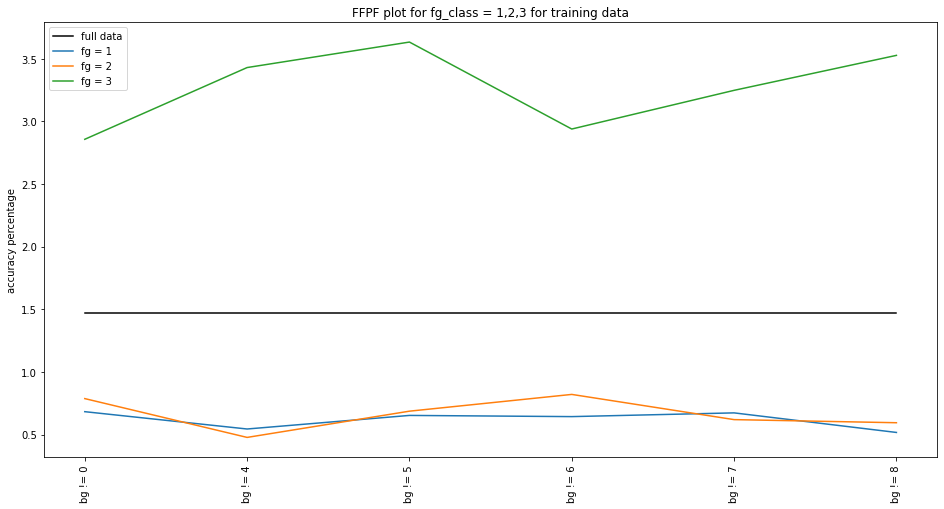

In [36]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

## On Test DATA


In [37]:
size1_table=[]
size1_table.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    b1 = i
    count = 0
    correct = 0
    total = 0
    focus_true_pred_true = 0
    focus_false_pred_true = 0
    focus_true_pred_false = 0
    focus_false_pred_false = 0
    argmax_more_than_half = 0
    argmax_less_than_half = 0
    with torch.no_grad():
      for data in test_set:
        inputs, labels , fore_idx = data
        inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
        outputs, alphas, avg_images = fore_net(inputs)

        _, predicted = torch.max(outputs.data, 1)

        for m in range(labels.size(0)):
          # count
          if(count == 10000):
            break
          s = list_set_labels[count]
          # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
          if (a in s and b1 not in s ):
            # print(str(a)+str(b1)+str(b2)+str(b3))
            total += 1
            focus = torch.argmax(alphas[m])
            if alphas[m][focus] >= 0.5 :
              argmax_more_than_half += 1
            else:
              argmax_less_than_half += 1

            if(focus == fore_idx[m] and predicted[m] == labels[m]):
                focus_true_pred_true += 1
            elif(focus != fore_idx[m] and predicted[m] == labels[m]):
              focus_false_pred_true += 1
            elif(focus == fore_idx[m] and predicted[m] != labels[m]):
              focus_true_pred_false += 1
            elif(focus != fore_idx[m] and predicted[m] != labels[m]):
              focus_false_pred_false += 1
          
          count += 1
        
      correct += (predicted == labels).sum().item()  
      entry = [entry_no,'fg = '+str(a) , 'bg != '+ str(b1), total]
      if total == 0:
        entry.append(0)
        entry.append(0)
        entry.append(0)
        entry.append(0)
      else:
        entry.append((100 * focus_true_pred_true / total))
        entry.append( (100 * focus_false_pred_true / total))
        entry.append( ( 100 * focus_true_pred_false / total))
        entry.append( ( 100 * focus_false_pred_false / total))
      entry.append( argmax_more_than_half)
      size1_table.append(entry)
      entry_no += 1

print("="*20+"Test DATA"+"="*20)
print(tabulate(size1_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Test DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          10000    64.96      15.41      4.23       15.4                7664
      2  fg = 1          bg != 0                               939    63.0458    17.2524    3.62087    16.0809              728
      3  fg = 1          bg != 4                               998    64.3287    15.5311    3.60721    16.5331              762
      4  fg = 1          bg != 5                               977    63.4596    15.1484    5.01535    16.3767              752
      5  fg = 1          bg != 6                               992    65.3226    16.3306    3.02419    15.3226              759
      6  fg = 1          bg != 7                      

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_" + str(fg_used) + "/" + "size1_on_test.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size1_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size1_table[i])

In [39]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_"+str(fg_used) + "/" + "size1_on_test.csv")
test.head()

S.No.        fg_class  ...    FFPF %   avg_img > 0.5
0      1  fg = [1, 2, 3]  ...  15.400000           7664
1      2          fg = 1  ...  16.080937            728
2      3          fg = 1  ...  16.533066            762
3      4          fg = 1  ...  16.376663            752
4      5          fg = 1  ...  15.322581            759

[5 rows x 9 columns]

In [40]:
test = np.array(test)
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,7  
id0 = test[l:u, 2]
ftpt0 = test[l:u, 4]
ffpt0 = test[l:u, 5]
ftpf0 = test[l:u, 6]
ffpf0 = test[l:u, 7]
print(ftpt0)

l,u = 8,14
id1 = test[l:u, 2]
ftpt1 = test[l:u, 4]
ffpt1 = test[l:u, 5]
ftpf1 = test[l:u, 6]
ffpf1 = test[l:u, 7]
print(ftpt1)

l,u = 15,21
id2 = test[l:u, 2]
ftpt2 = test[l:u, 4]
ffpt2 = test[l:u, 5]
ftpf2 = test[l:u, 6]
ffpf2 = test[l:u, 7]
print(ftpt2)

64.96 15.41 4.23 15.4
[63.045793397231094 64.32865731462925 63.45957011258956 65.3225806451613
 64.66321243523315 65.83333333333333]
[67.3277661795407 65.59679037111334 66.16766467065868 64.21825813221406
 64.33054393305439 65.48582995951416]
[66.66666666666667 67.83144912641315 65.13089005235602 66.84378320935176
 64.4120707596254 66.49377593360995]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_' + str(fg_used) + "/size1/test/"

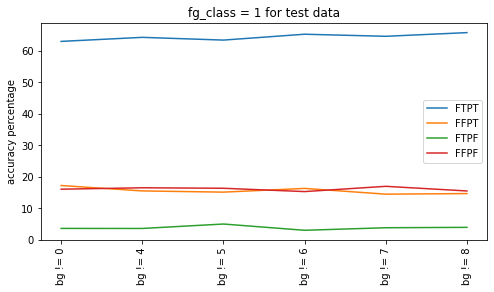

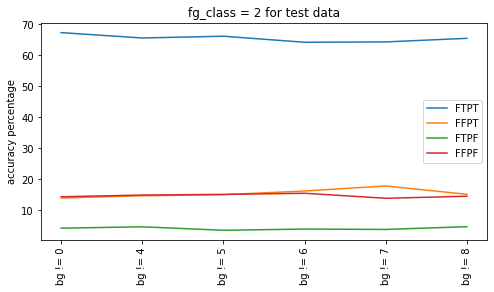

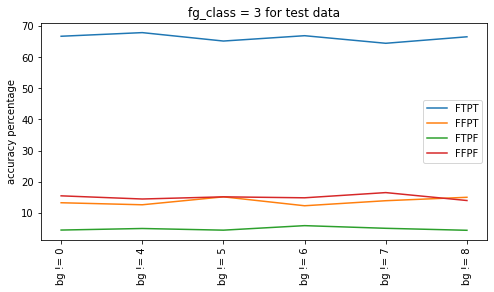

In [42]:
fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for test data'+".pdf", bbox_inches='tight')

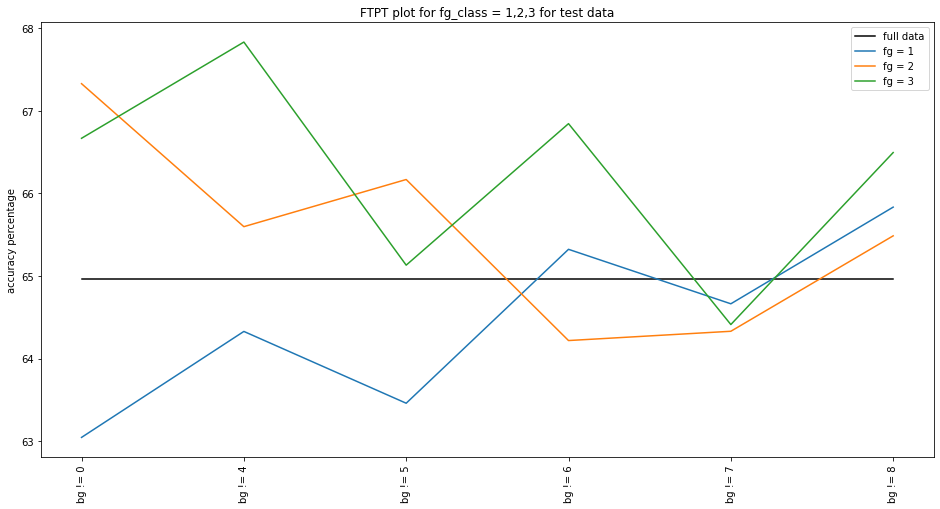

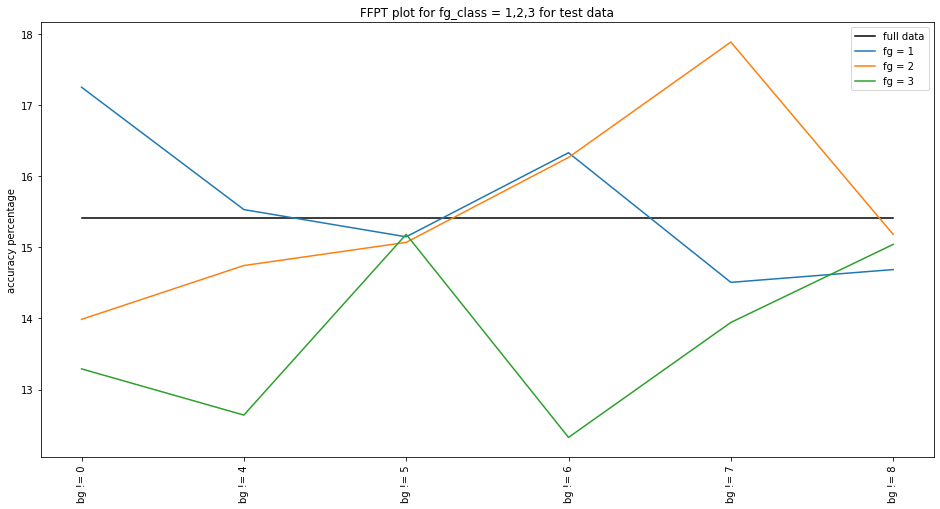

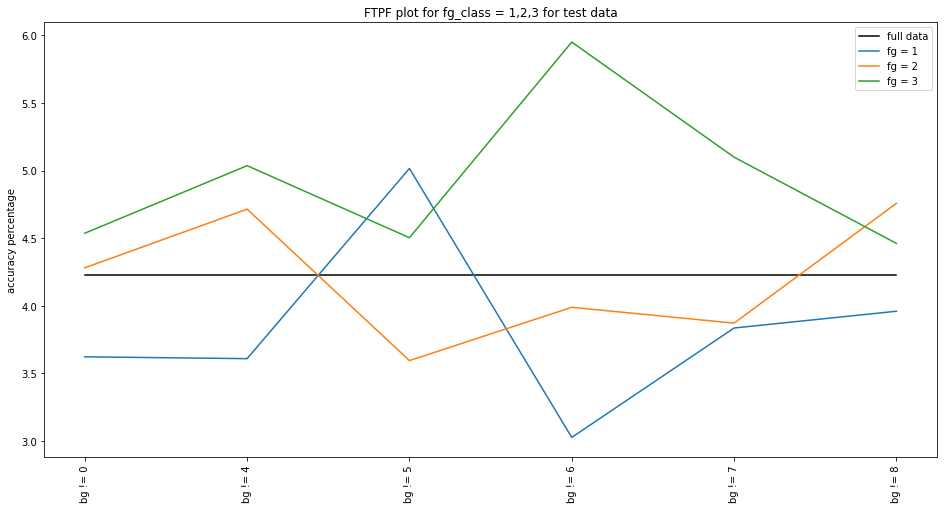

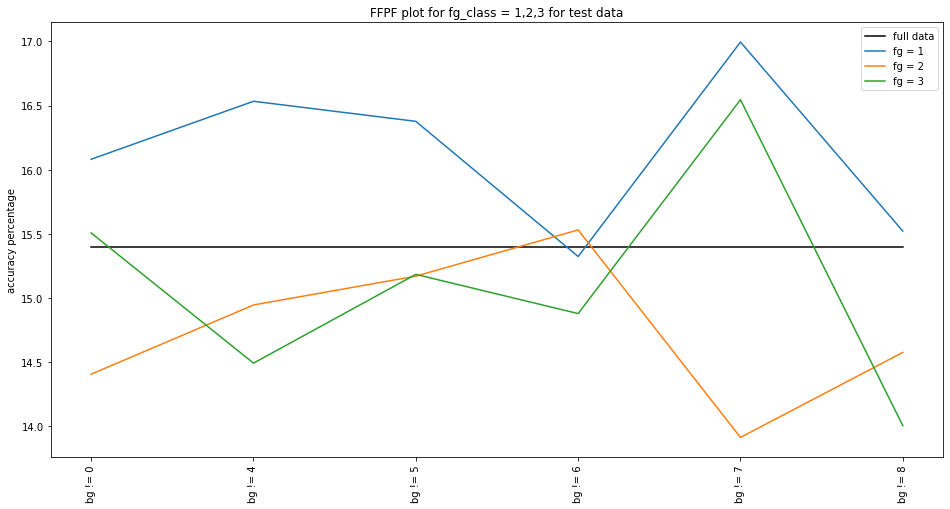

In [43]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

#Set Size 2 , Repetition allowed
## 33 in BG, 34 in BG, 35 in BG and so on
## On Training DATA


In [44]:
size2_table=[]
size2_table.append(train_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      b1, b2 = i,j
      count = 0
      correct = 0
      total = 0
      focus_true_pred_true = 0
      focus_false_pred_true = 0
      focus_true_pred_false = 0
      focus_false_pred_false = 0
      argmax_more_than_half = 0
      argmax_less_than_half = 0
      with torch.no_grad():
        for data in train_set:
          inputs, labels , fore_idx = data
          inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
          outputs, alphas, avg_images = fore_net(inputs)

          _, predicted = torch.max(outputs.data, 1)

          for m in range(labels.size(0)):
            # count
            if(count == 30000):
              break
            s = list_set_labels[count]
            # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
            if (a in s and b1 not in s and b2 not in s ):
              # print(str(a)+str(b1)+str(b2)+str(b3))
              total += 1
              focus = torch.argmax(alphas[m])
              if alphas[m][focus] >= 0.5 :
                argmax_more_than_half += 1
              else:
                argmax_less_than_half += 1

              if(focus == fore_idx[m] and predicted[m] == labels[m]):
                  focus_true_pred_true += 1
              elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                focus_false_pred_true += 1
              elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                focus_true_pred_false += 1
              elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                focus_false_pred_false += 1
            
            count += 1
          
        correct += (predicted == labels).sum().item()  
        entry = [entry_no,'fg = '+str(a) , 'bg != '+ str(b1) + str(b2), total]
        if total == 0:
          entry.append(0)
          entry.append(0)
          entry.append(0)
          entry.append(0)
        else:
          entry.append((100 * focus_true_pred_true / total))
          entry.append( (100 * focus_false_pred_true / total))
          entry.append( ( 100 * focus_true_pred_false / total))
          entry.append( ( 100 * focus_false_pred_false / total))
        entry.append( argmax_more_than_half)
        size2_table.append(entry)
        entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(size2_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          30000    73.2367   24.9833   0.306667    1.47333             24397
      2  fg = 1          bg != 00                             2929    94.9129    4.26767  0.136565    0.682827             2873
      3  fg = 1          bg != 04                              681    94.5668    4.40529  0.440529    0.587372              668
      4  fg = 1          bg != 05                              653    94.7933    4.44104  0           0.765697              640
      5  fg = 1          bg != 06                              732    94.5355    3.96175  0.409836    1.0929                717
      6  fg = 1          bg != 07                 

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_" + str(fg_used) + "/" + "size2_on_train.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size2_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size2_table[i])

In [46]:
train = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_"+str(fg_used) + "/" + "size2_on_train.csv")
train.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [1, 2, 3]  ...  1.473333          24397
1      2          fg = 1  ...  0.682827           2873
2      3          fg = 1  ...  0.587372            668
3      4          fg = 1  ...  0.765697            640
4      5          fg = 1  ...  1.092896            717

[5 rows x 9 columns]

In [47]:
train = np.array(train)
ftpt_full = train[0][4]
ffpt_full = train[0, 5]
ftpf_full = train[0, 6]
ffpf_full = train[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,49
id0 = train[l:u, 2]
ftpt0 = train[l:u, 4]
ffpt0 = train[l:u, 5]
ftpf0 = train[l:u, 6]
ffpf0 = train[l:u, 7]
print(ftpt0[0:4] )

l,u = 50,98
id1 = train[l:u, 2]
ftpt1 = train[l:u, 4]
ffpt1 = train[l:u, 5]
ftpf1 = train[l:u, 6]
ffpf1 = train[l:u, 7]
print(ftpt1[0:4] )

l,u = 99,147
id2 = train[l:u, 2]
ftpt2 = train[l:u, 4]
ffpt2 = train[l:u, 5]
ftpf2 = train[l:u, 6]
ffpf2 = train[l:u, 7]
print(ftpt2[0:4] )

73.23666666666666 24.98333333333333 0.30666666666666664 1.4733333333333334
[94.91293956981905 94.56681350954479 94.79326186830015 94.53551912568308]
[70.12320328542093 71.98211624441133 69.2762186115214 67.66917293233082]
[53.84883315917799 55.07020280811233 54.23728813559321 56.288343558282214]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_' + str(fg_used) + "/size2/train/"

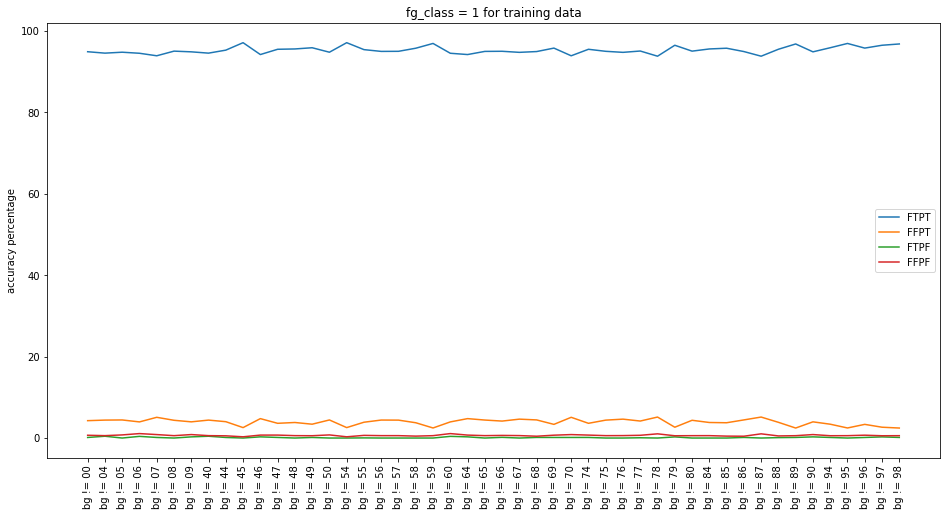

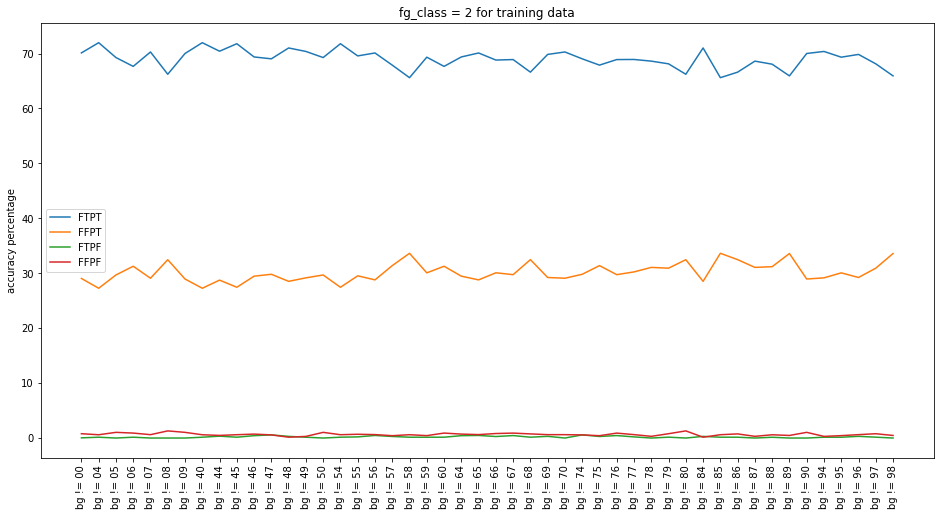

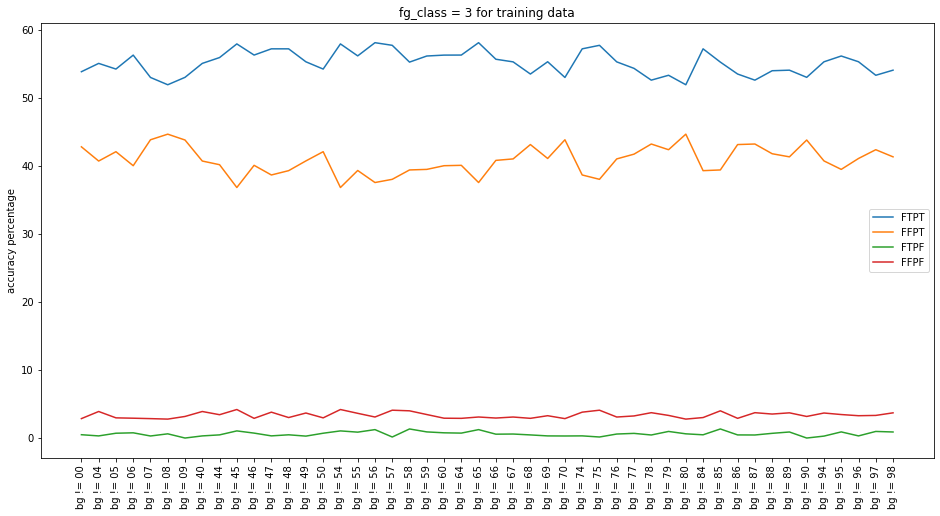

In [49]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for training data'+".pdf", bbox_inches='tight')

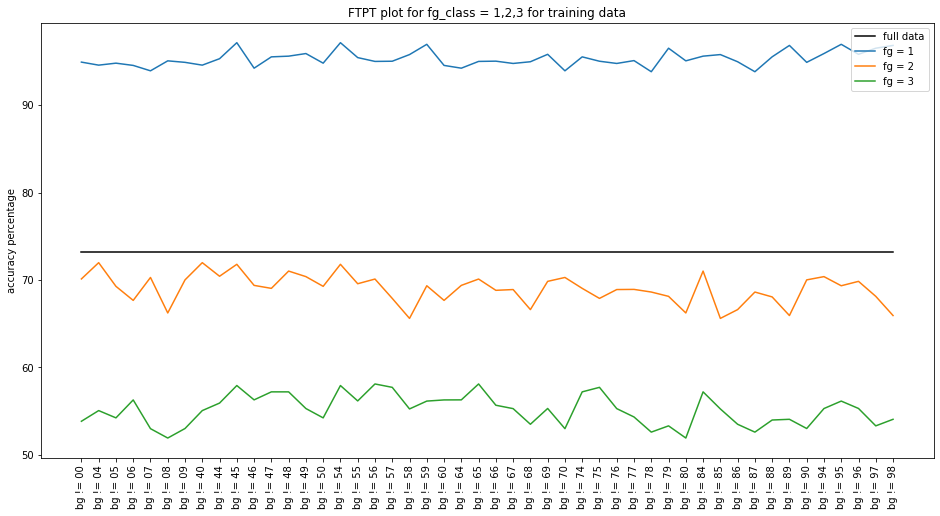

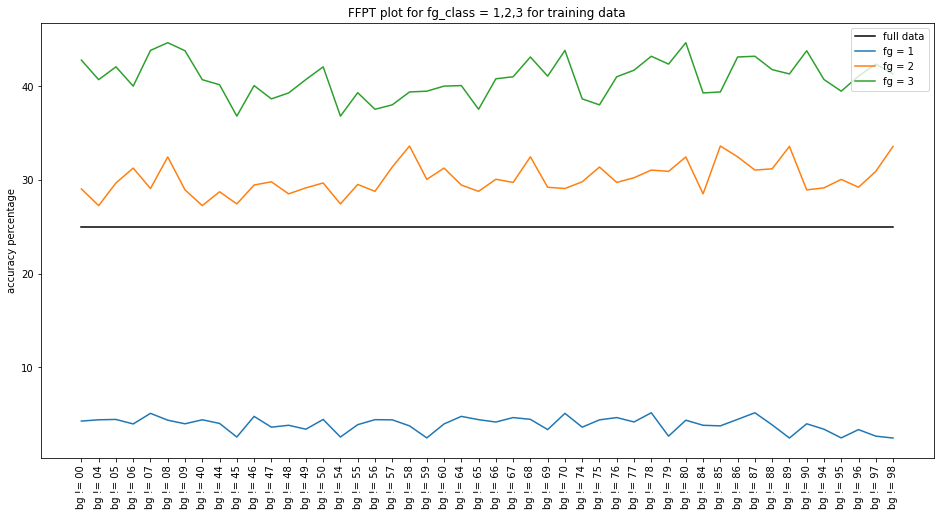

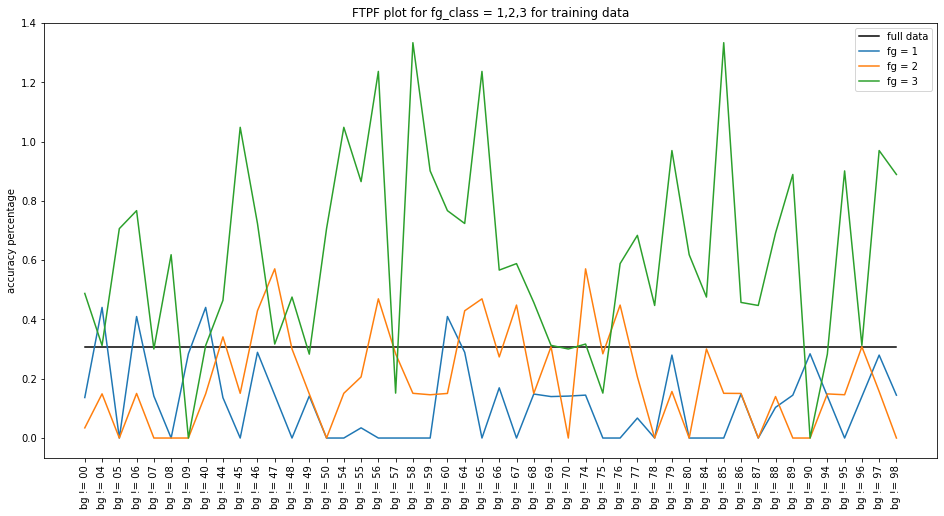

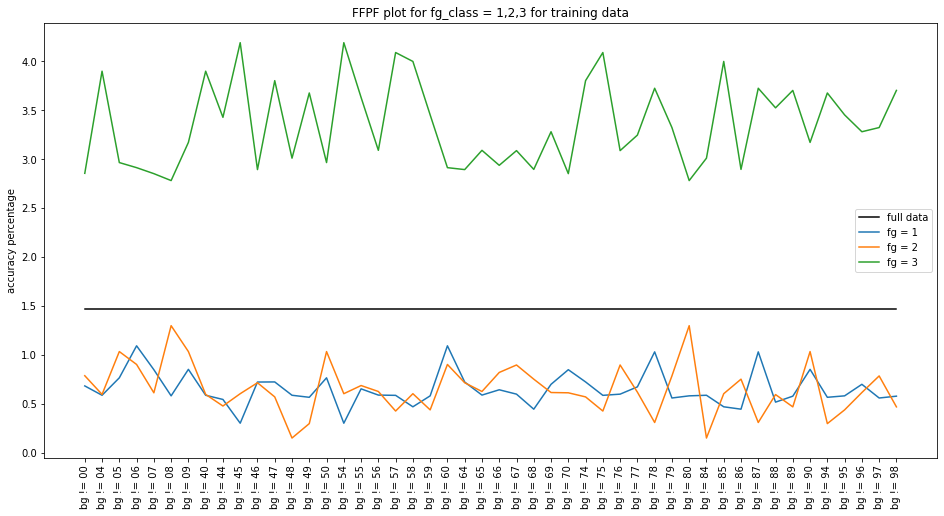

In [50]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

## On Test DATA


In [51]:
size2_table_test=[]
size2_table_test.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      b1,b2 = i,j
      count = 0
      correct = 0
      total = 0
      focus_true_pred_true = 0
      focus_false_pred_true = 0
      focus_true_pred_false = 0
      focus_false_pred_false = 0
      argmax_more_than_half = 0
      argmax_less_than_half = 0
      with torch.no_grad():
        for data in test_set:
          inputs, labels , fore_idx = data
          inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
          outputs, alphas, avg_images = fore_net(inputs)

          _, predicted = torch.max(outputs.data, 1)

          for m in range(labels.size(0)):
            # count
            if(count == 10000):
              break
            s = list_set_labels[count]
            # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
            if (a in s and b1 not in s and b2 not in s ):
              # print(str(a)+str(b1)+str(b2)+str(b3))
              total += 1
              focus = torch.argmax(alphas[m])
              if alphas[m][focus] >= 0.5 :
                argmax_more_than_half += 1
              else:
                argmax_less_than_half += 1

              if(focus == fore_idx[m] and predicted[m] == labels[m]):
                  focus_true_pred_true += 1
              elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                focus_false_pred_true += 1
              elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                focus_true_pred_false += 1
              elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                focus_false_pred_false += 1
            
            count += 1
          
        correct += (predicted == labels).sum().item()  
        entry = [entry_no,'fg = '+str(a) , 'bg != '+ str(b1)+str(b2), total]
        if total == 0:
          entry.append(0)
          entry.append(0)
          entry.append(0)
          entry.append(0)
        else:
          entry.append((100 * focus_true_pred_true / total))
          entry.append( (100 * focus_false_pred_true / total))
          entry.append( ( 100 * focus_true_pred_false / total))
          entry.append( ( 100 * focus_false_pred_false / total))
        entry.append( argmax_more_than_half)
        size2_table_test.append(entry)
        entry_no += 1

print("="*20+"Test DATA"+"="*20)
print(tabulate(size2_table_test, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Test DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          10000    64.96      15.41      4.23      15.4                 7664
      2  fg = 1          bg != 00                              939    63.0458    17.2524    3.62087   16.0809               728
      3  fg = 1          bg != 04                              228    62.2807    20.1754    2.19298   15.3509               171
      4  fg = 1          bg != 05                              216    57.8704    18.0556    4.16667   19.9074               166
      5  fg = 1          bg != 06                              241    62.2407    17.8423    2.48963   17.4274               189
      6  fg = 1          bg != 07                     

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_" + str(fg_used) + "/" + "size2_on_test.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size2_table_test)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size2_table_test[i])

In [53]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_"+str(fg_used) + "/" + "size2_on_test.csv")
test.head()

S.No.        fg_class  ...    FFPF %   avg_img > 0.5
0      1  fg = [1, 2, 3]  ...  15.400000           7664
1      2          fg = 1  ...  16.080937            728
2      3          fg = 1  ...  15.350877            171
3      4          fg = 1  ...  19.907407            166
4      5          fg = 1  ...  17.427386            189

[5 rows x 9 columns]

In [54]:
test = np.array(test)
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,49
id0 = test[l:u, 2]
ftpt0 = test[l:u, 4]
ffpt0 = test[l:u, 5]
ftpf0 = test[l:u, 6]
ffpf0 = test[l:u, 7]
print(ftpt0[0:4])

l,u = 50,98
id1 = test[l:u, 2]
ftpt1 = test[l:u, 4]
ffpt1 = test[l:u, 5]
ftpf1 = test[l:u, 6]
ffpf1 = test[l:u, 7]
print(ftpt1[0:4] )

l,u = 99,147
id2 = test[l:u, 2]
ftpt2 = test[l:u, 4]
ffpt2 = test[l:u, 5]
ftpf2 = test[l:u, 6]
ffpf2 = test[l:u, 7]
print(ftpt2[0:4] )

64.96 15.41 4.23 15.4
[63.045793397231094 62.280701754385966 57.87037037037037 62.24066390041494]
[67.3277661795407 66.21621621621621 64.8068669527897 70.47619047619048]
[66.66666666666667 66.81614349775785 65.61085972850678 64.47368421052633]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_' + str(fg_used) + "/size2/test/"

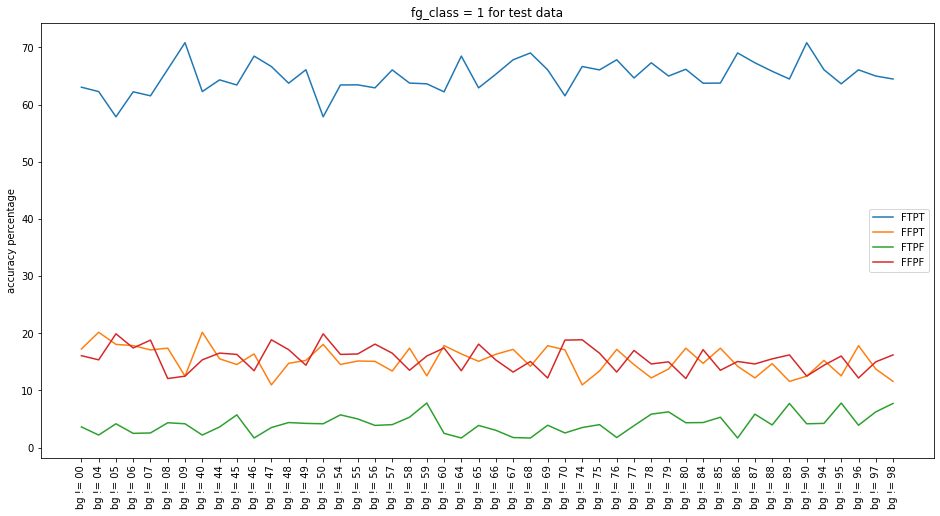

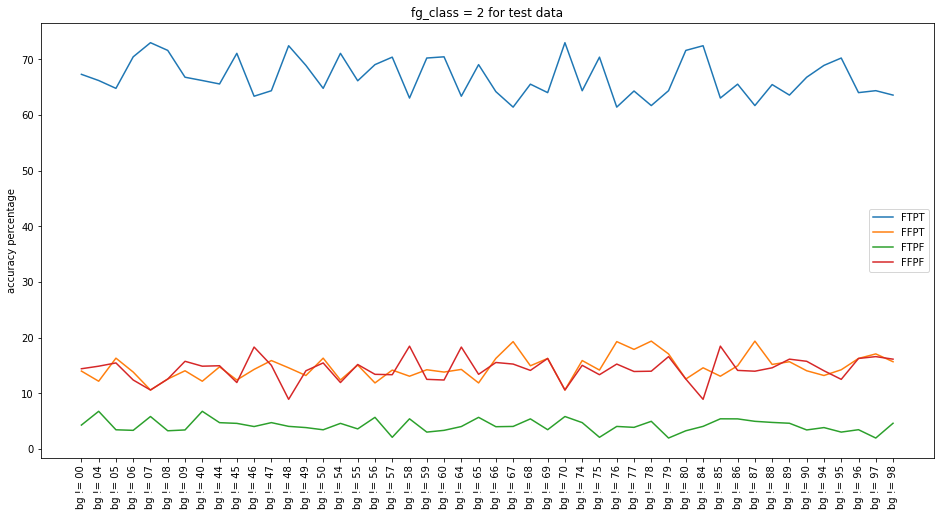

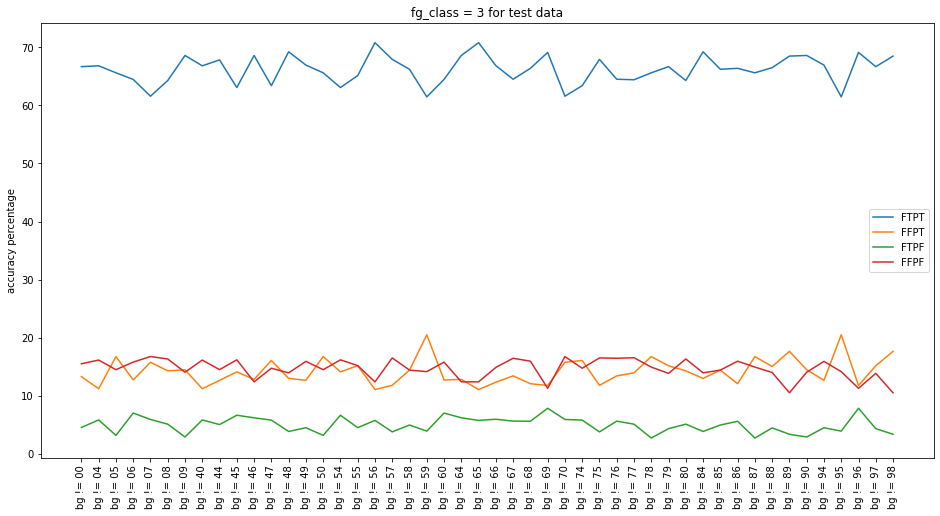

In [56]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for test data'+".pdf", bbox_inches='tight')

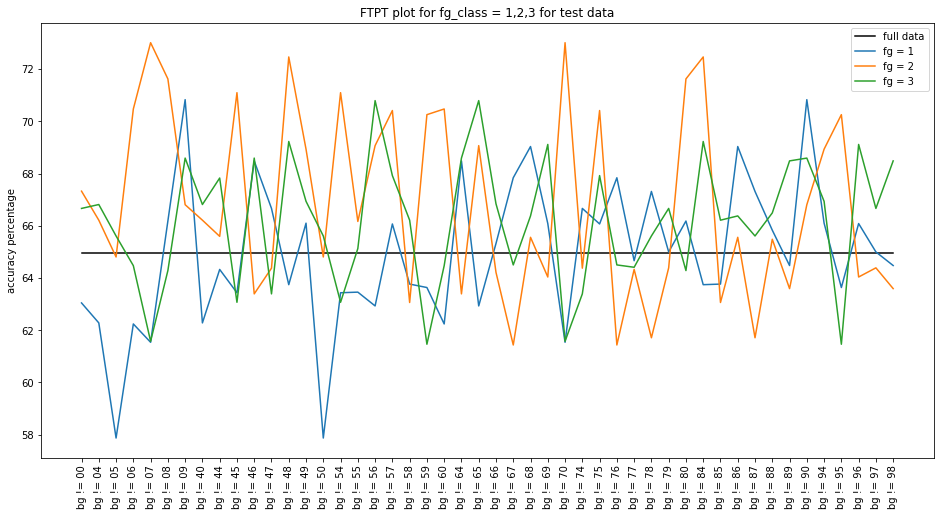

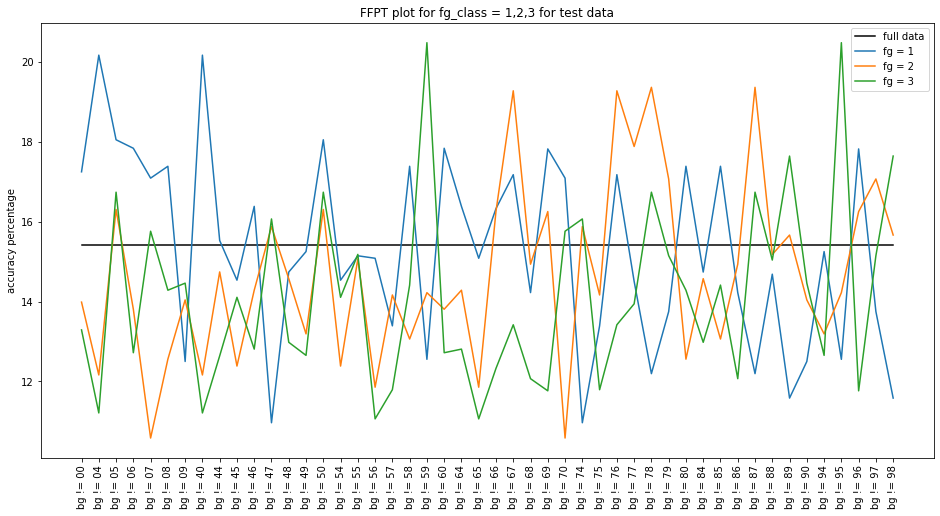

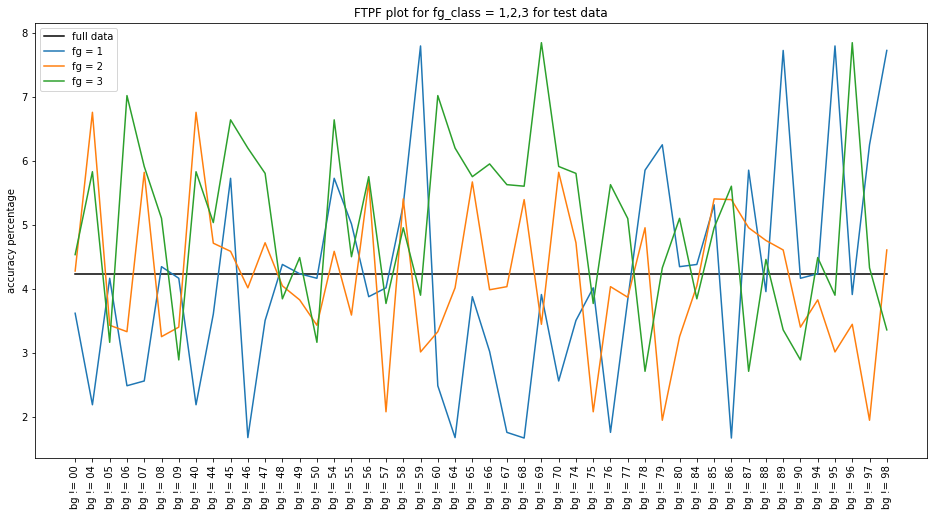

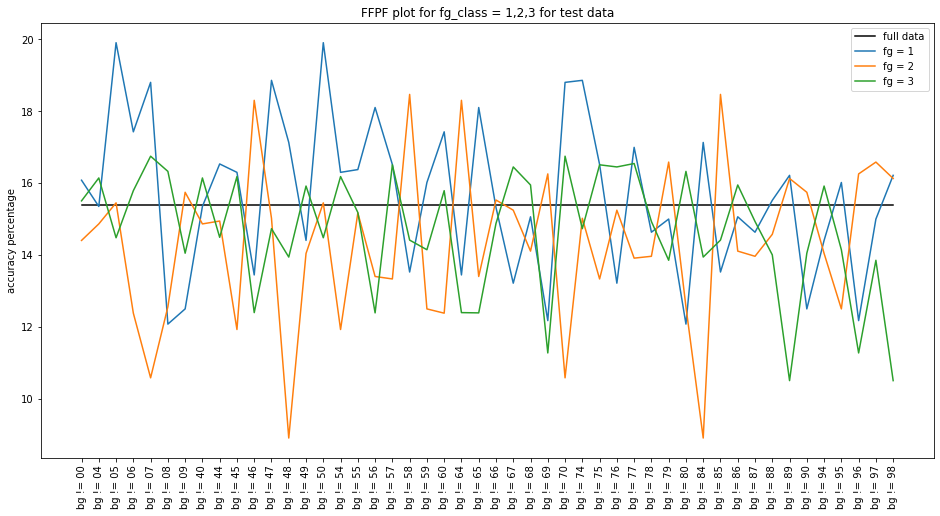

In [57]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

#Set Size 3 , Repetition allowed
## 333 in BG, 334 in BG, 335 in BG and so on
## On Training DATA


In [58]:
size3_table=[]
size3_table.append(train_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      for k in bg:
        b1, b2, b3 = i,j,k
        count = 0
        correct = 0
        total = 0
        focus_true_pred_true = 0
        focus_false_pred_true = 0
        focus_true_pred_false = 0
        focus_false_pred_false = 0
        argmax_more_than_half = 0
        argmax_less_than_half = 0
        with torch.no_grad():
          for data in train_set:
            inputs, labels , fore_idx = data
            inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
            outputs, alphas, avg_images = fore_net(inputs)

            _, predicted = torch.max(outputs.data, 1)

            for m in range(labels.size(0)):
              # count
              if(count == 30000):
                break
              s = list_set_labels[count]
              # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
              if (a in s and b1 not in s and b2 not in s and b3 not in s ):
                # print(str(a)+str(b1)+str(b2)+str(b3))
                total += 1
                focus = torch.argmax(alphas[m])
                if alphas[m][focus] >= 0.5 :
                  argmax_more_than_half += 1
                else:
                  argmax_less_than_half += 1

                if(focus == fore_idx[m] and predicted[m] == labels[m]):
                    focus_true_pred_true += 1
                elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                  focus_false_pred_true += 1
                elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                  focus_true_pred_false += 1
                elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                  focus_false_pred_false += 1
              
              count += 1
            
          correct += (predicted == labels).sum().item()  
          entry = [entry_no,'fg = '+str(a) , 'bg != '+ str(b1) + str(b2) +str(b3), total]
          if total == 0:
            entry.append(0)
            entry.append(0)
            entry.append(0)
            entry.append(0)
          else:
            entry.append((100 * focus_true_pred_true / total))
            entry.append( (100 * focus_false_pred_true / total))
            entry.append( ( 100 * focus_true_pred_false / total))
            entry.append( ( 100 * focus_false_pred_false / total))
          entry.append( argmax_more_than_half)
          size3_table.append(entry)
          entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(size3_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          30000    73.2367  24.9833    0.306667    1.47333             24397
      2  fg = 1          bg != 000                            2929    94.9129   4.26767   0.136565    0.682827             2873
      3  fg = 1          bg != 004                             681    94.5668   4.40529   0.440529    0.587372              668
      4  fg = 1          bg != 005                             653    94.7933   4.44104   0           0.765697              640
      5  fg = 1          bg != 006                             732    94.5355   3.96175   0.409836    1.0929                717
      6  fg = 1          bg != 007                

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_" + str(fg_used) + "/" + "size3_on_train.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size3_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size3_table[i])

In [60]:
train = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_"+str(fg_used) + "/" + "size3_on_train.csv")
train.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [1, 2, 3]  ...  1.473333          24397
1      2          fg = 1  ...  0.682827           2873
2      3          fg = 1  ...  0.587372            668
3      4          fg = 1  ...  0.765697            640
4      5          fg = 1  ...  1.092896            717

[5 rows x 9 columns]

In [61]:
train = np.array(train)
ftpt_full = train[0][4]
ffpt_full = train[0, 5]
ftpf_full = train[0, 6]
ffpf_full = train[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,343
id0 = train[l:u, 2]
ftpt0 = train[l:u, 4]
ffpt0 = train[l:u, 5]
ftpf0 = train[l:u, 6]
ffpf0 = train[l:u, 7]
print(ftpt0[0:4] )

l,u = 344,686
id1 = train[l:u, 2]
ftpt1 = train[l:u, 4]
ffpt1 = train[l:u, 5]
ftpf1 = train[l:u, 6]
ffpf1 = train[l:u, 7]
print(ftpt1[0:4] )

l,u = 687,1029
id2 = train[l:u, 2]
ftpt2 = train[l:u, 4]
ffpt2 = train[l:u, 5]
ftpf2 = train[l:u, 6]
ffpf2 = train[l:u, 7]
print(ftpt2[0:4] )

73.23666666666666 24.98333333333333 0.30666666666666664 1.4733333333333334
[94.91293956981905 94.56681350954479 94.79326186830015 94.53551912568308]
[70.12320328542093 71.98211624441133 69.2762186115214 67.66917293233082]
[53.84883315917799 55.07020280811233 54.23728813559321 56.288343558282214]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_' + str(fg_used) + "/size3/train/"

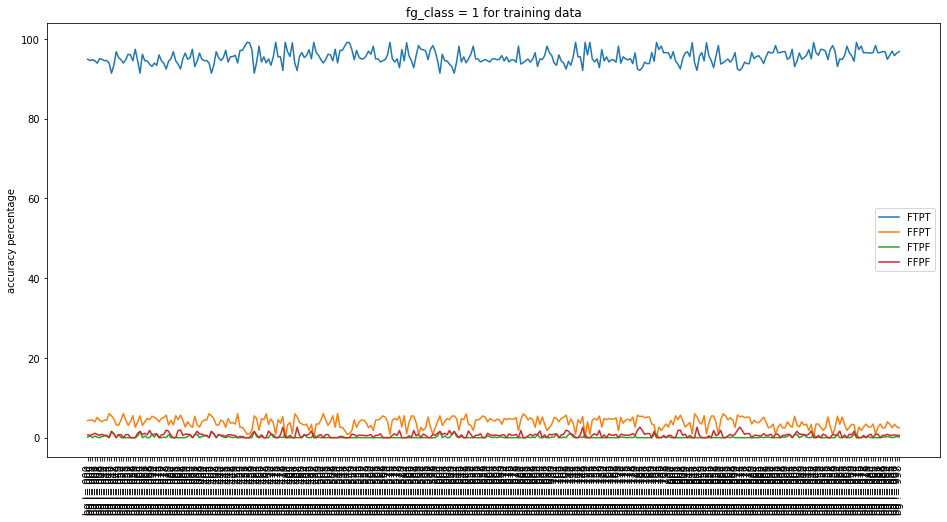

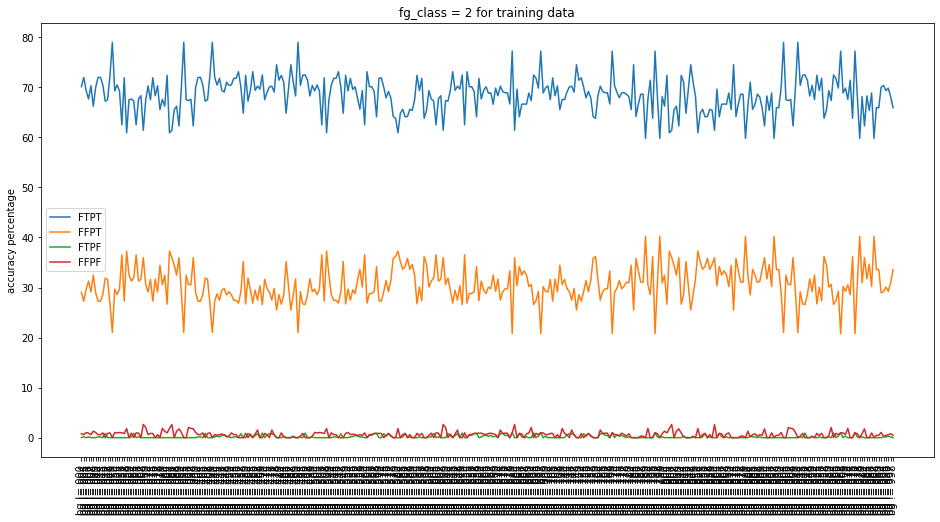

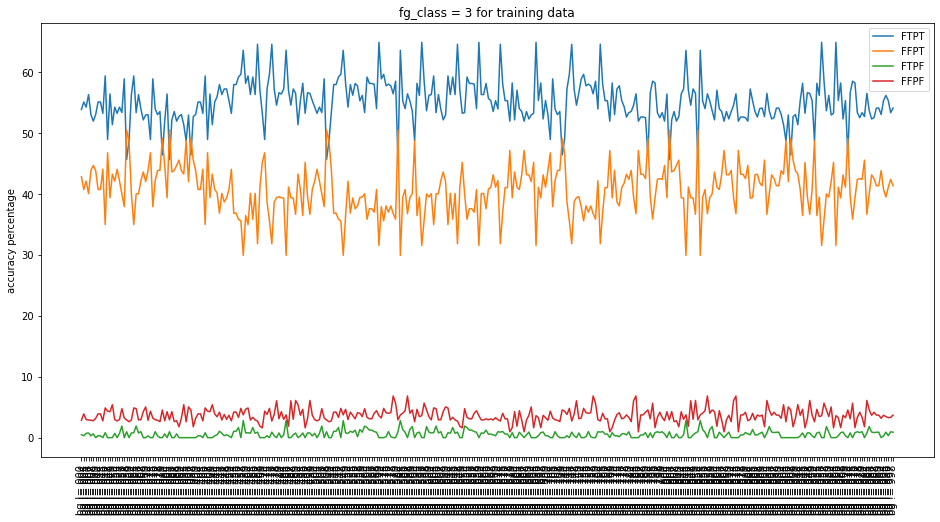

In [63]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for training data'+".pdf", bbox_inches='tight')

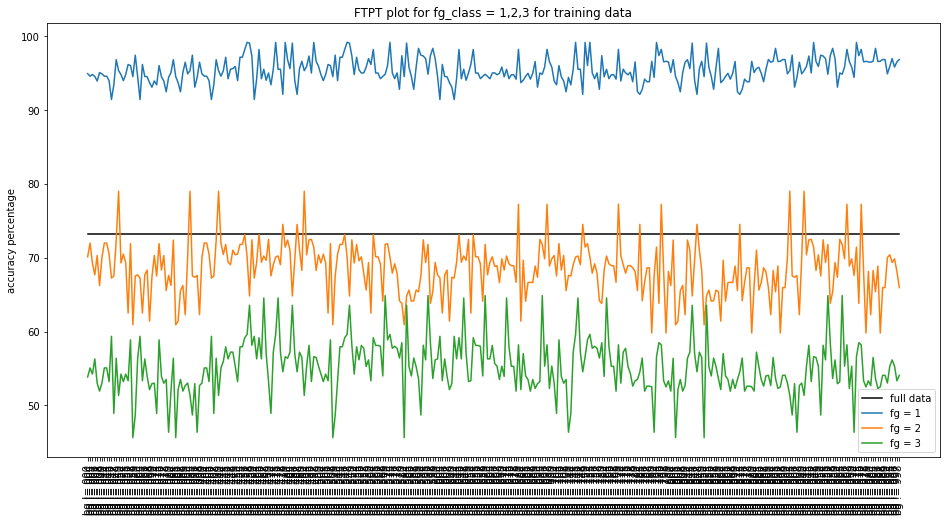

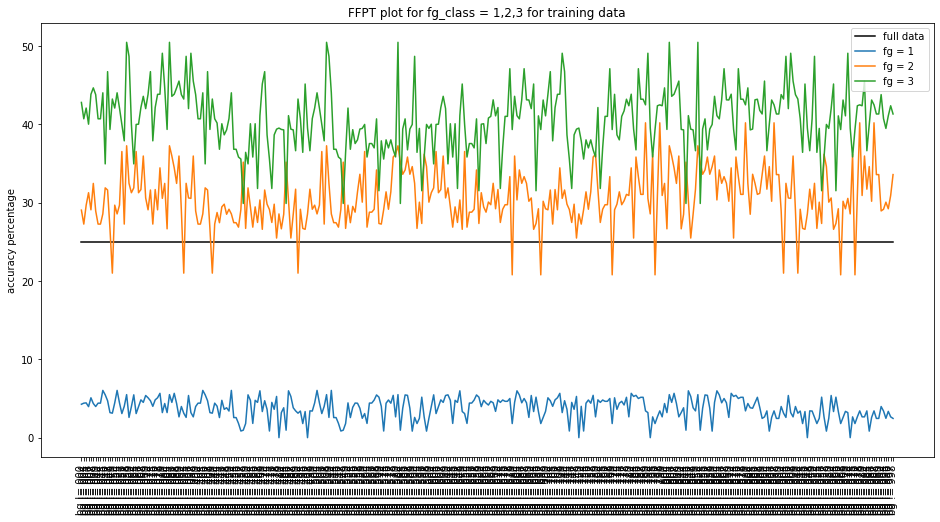

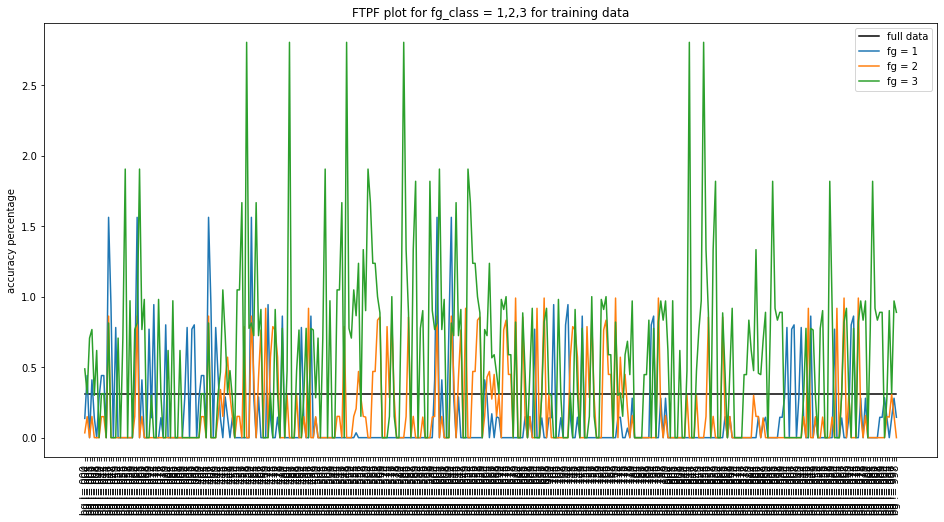

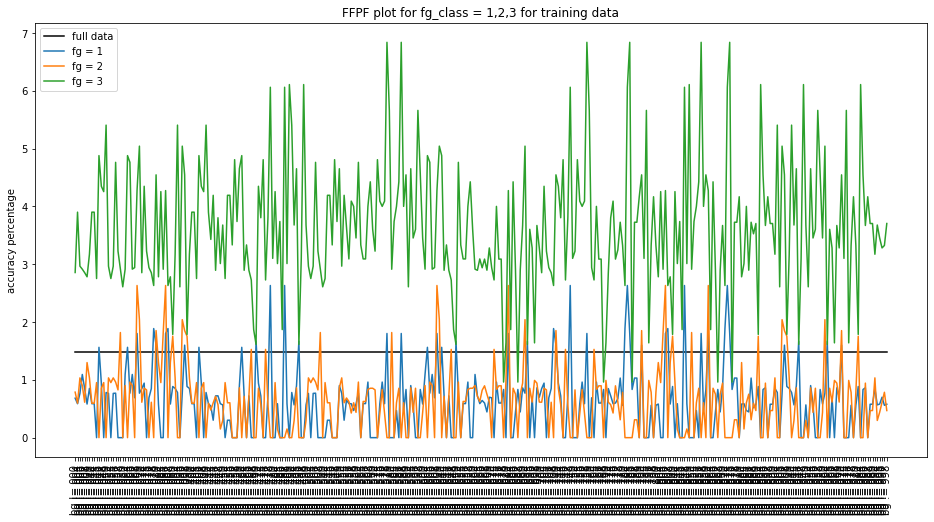

In [64]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

## On Test DATA


In [65]:
size3_table_test=[]
size3_table_test.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      for k in bg:
        b1,b2,b3 = i,j,k
        count = 0
        correct = 0
        total = 0
        focus_true_pred_true = 0
        focus_false_pred_true = 0
        focus_true_pred_false = 0
        focus_false_pred_false = 0
        argmax_more_than_half = 0
        argmax_less_than_half = 0
        with torch.no_grad():
          for data in test_set:
            inputs, labels , fore_idx = data
            inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
            outputs, alphas, avg_images = fore_net(inputs)

            _, predicted = torch.max(outputs.data, 1)

            for m in range(labels.size(0)):
              # count
              if(count == 10000):
                break
              s = list_set_labels[count]
              # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
              if (a in s and b1 not in s and b2 not in s and b3 not in s):
                # print(str(a)+str(b1)+str(b2)+str(b3))
                total += 1
                focus = torch.argmax(alphas[m])
                if alphas[m][focus] >= 0.5 :
                  argmax_more_than_half += 1
                else:
                  argmax_less_than_half += 1

                if(focus == fore_idx[m] and predicted[m] == labels[m]):
                    focus_true_pred_true += 1
                elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                  focus_false_pred_true += 1
                elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                  focus_true_pred_false += 1
                elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                  focus_false_pred_false += 1
              
              count += 1
            
          correct += (predicted == labels).sum().item()  
          entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1)+str(b2)+str(b3), total]
          if total == 0:
            entry.append(0)
            entry.append(0)
            entry.append(0)
            entry.append(0)
          else:
            entry.append((100 * focus_true_pred_true / total))
            entry.append( (100 * focus_false_pred_true / total))
            entry.append( ( 100 * focus_true_pred_false / total))
            entry.append( ( 100 * focus_false_pred_false / total))
          entry.append( argmax_more_than_half)
          size3_table_test.append(entry)
          entry_no += 1

print("="*20+"Test DATA"+"="*20)
print(tabulate(size3_table_test, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Test DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          10000    64.96     15.41       4.23      15.4                 7664
      2  fg = 1          bg = 000                              939    63.0458   17.2524     3.62087   16.0809               728
      3  fg = 1          bg = 004                              228    62.2807   20.1754     2.19298   15.3509               171
      4  fg = 1          bg = 005                              216    57.8704   18.0556     4.16667   19.9074               166
      5  fg = 1          bg = 006                              241    62.2407   17.8423     2.48963   17.4274               189
      6  fg = 1          bg = 007                     

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_" + str(fg_used) + "/" + "size3_on_test.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size3_table_test)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size3_table_test[i])

In [67]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_"+str(fg_used) + "/" + "size3_on_test.csv")
test.head()

S.No.        fg_class  ...    FFPF %   avg_img > 0.5
0      1  fg = [1, 2, 3]  ...  15.400000           7664
1      2          fg = 1  ...  16.080937            728
2      3          fg = 1  ...  15.350877            171
3      4          fg = 1  ...  19.907407            166
4      5          fg = 1  ...  17.427386            189

[5 rows x 9 columns]

In [68]:
test = np.array(test)
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,343
id0 = test[l:u, 2]
ftpt0 = test[l:u, 4]
ffpt0 = test[l:u, 5]
ftpf0 = test[l:u, 6]
ffpf0 = test[l:u, 7]
print(ftpt0[0:4])

l,u = 344,686
id1 = test[l:u, 2]
ftpt1 = test[l:u, 4]
ffpt1 = test[l:u, 5]
ftpf1 = test[l:u, 6]
ffpf1 = test[l:u, 7]
print(ftpt1[0:4] )

l,u = 687,1029
id2 = test[l:u, 2]
ftpt2 = test[l:u, 4]
ffpt2 = test[l:u, 5]
ftpf2 = test[l:u, 6]
ffpf2 = test[l:u, 7]
print(ftpt2[0:4] )

64.96 15.41 4.23 15.4
[63.045793397231094 62.280701754385966 57.87037037037037 62.24066390041494]
[67.3277661795407 66.21621621621621 64.8068669527897 70.47619047619048]
[66.66666666666667 66.81614349775785 65.61085972850678 64.47368421052633]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_' + str(fg_used) + "/size3/test/"

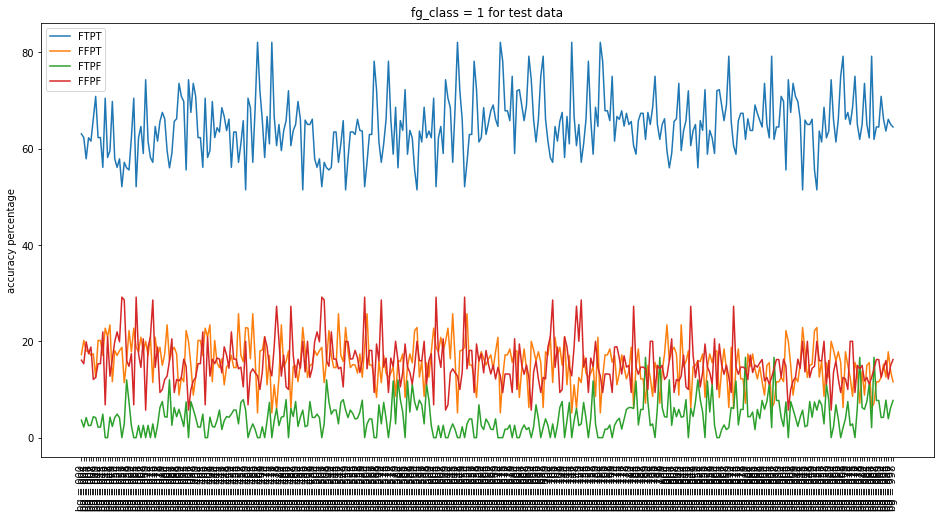

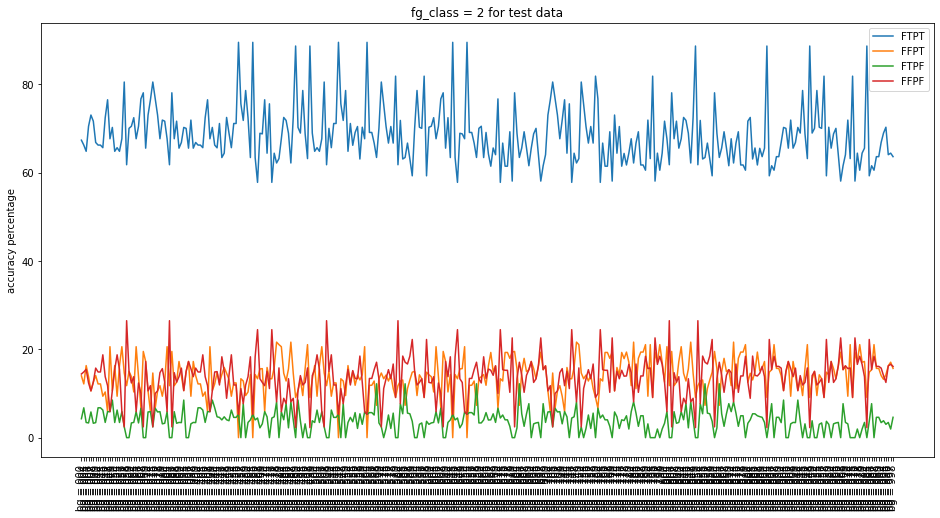

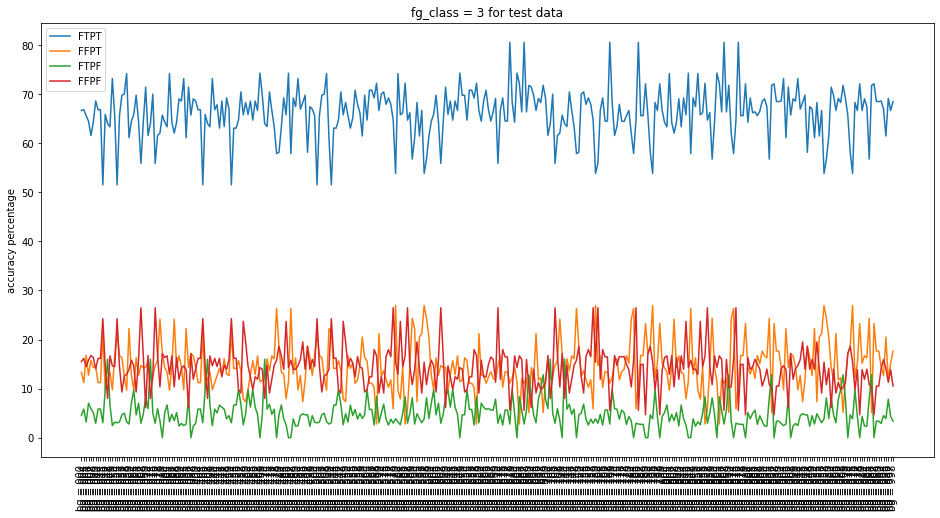

In [70]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for test data'+".pdf", bbox_inches='tight')

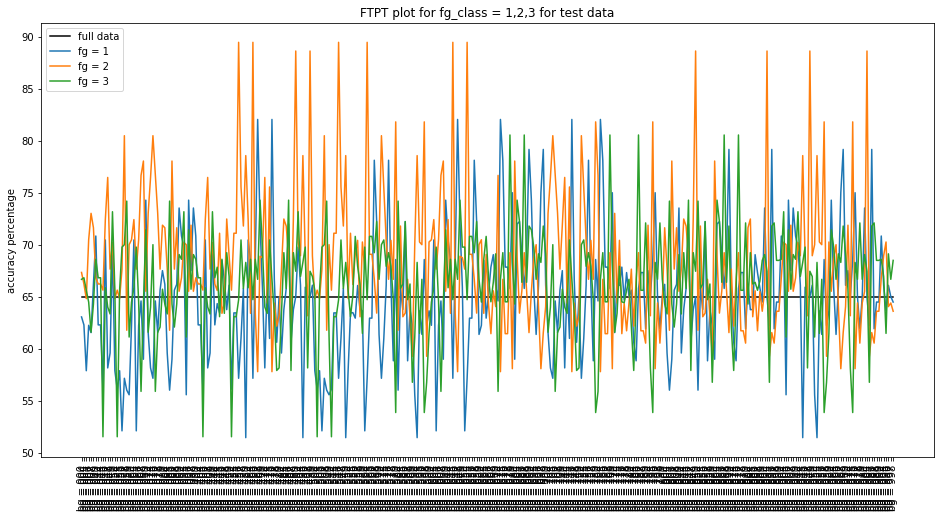

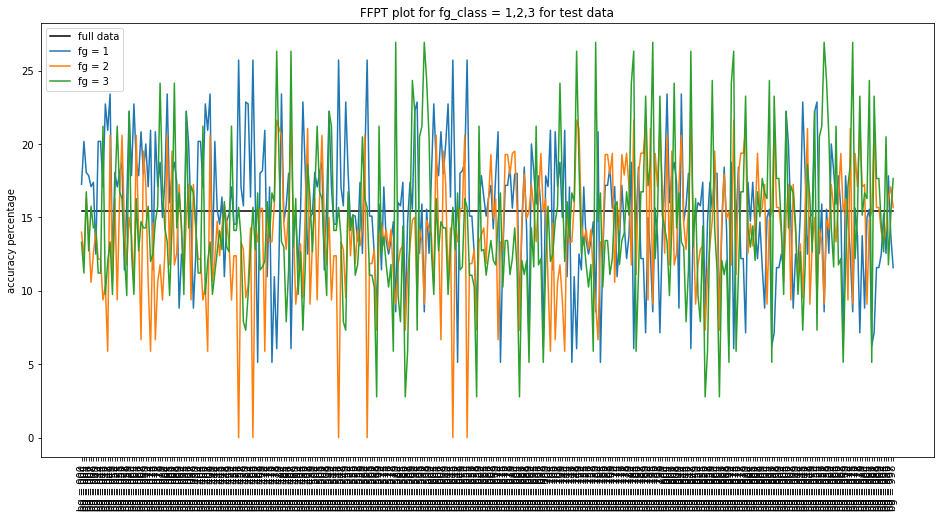

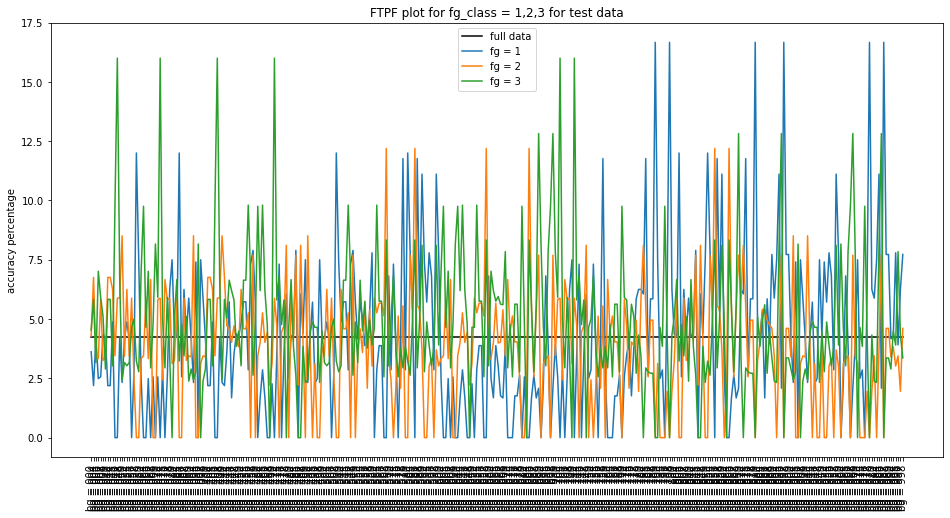

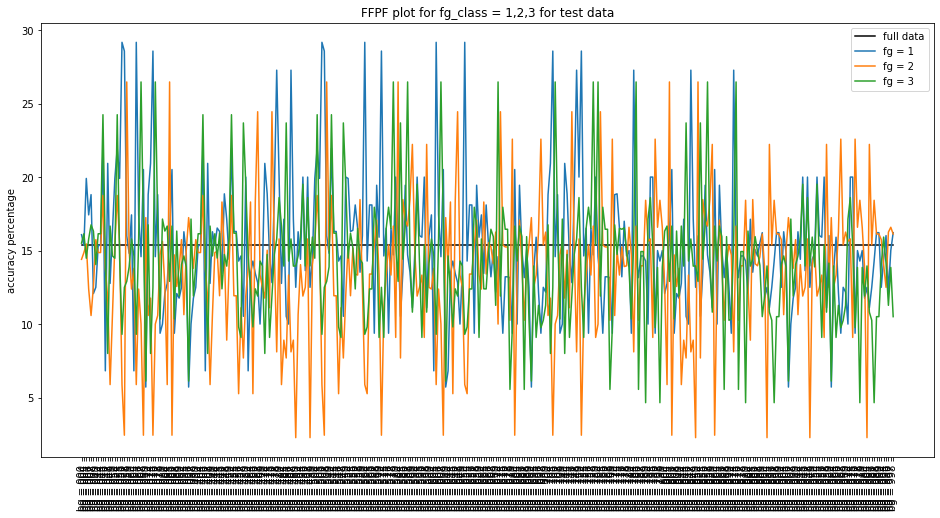

In [71]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')